In [1]:
import matplotlib.pyplot as plt # per i plot
import numpy as np # per manipolazione vettori
from scipy.odr import * # per i fit
from uncertainties import  ufloat
from uncertainties.umath import *
from math import sqrt
%matplotlib notebook

In [2]:
# definizione delle funzioni utili per i calcoli

# definisco la funzione di fit
def fit_function(params, x):
    return params[4]*(params[0]**2 + params[1]**2 + 2*params[0]*params[1]*np.cos(2*params[2]*x + params[3]))

# Calcolo del rapporto d'onda stazionaria
def rapporto_onda_stazionaria(U_F, U_B):
    return (U_F + U_B) / (U_F - U_B)

# Calcolo dell'impedenza del carico
def impedenza_carico(impedenza_guida_onda, U_F, U_B, delta_phi):
    cos_phi = float(cos(delta_phi))
    sin_phi = float(sin(delta_phi))
    real = impedenza_guida_onda * (U_F**2 - U_B**2) / (U_F**2 + U_B**2 - 2*U_F*U_B*cos_phi)
    imaginary = impedenza_guida_onda * (2*U_F*U_B*sin_phi) / (U_F**2 + U_B**2 - 2*U_F*U_B*cos_phi)
    return real, imaginary

def calc_lambda_guida(nu, a, c):
    first = (nu/c)**2
    second = (1/(2*a))**2
    return (first - second)**(-1/2)

# Impedenza e SWR dei vari carichi

* Calcoliamo l'impedenza in guida d'onda 

1. Eseguiamo il fit della funzione
2. Calcoliamo impedenza del carico
3. Calcoliamo il rapporto $SWR$

## Impedenza in guida d'onda

$$
Z_{guida} = Z_0 \frac{\lambda_{guida}}{\lambda_{0}}\frac{2b}{a}
$$

Utilizziamo 
$$
Z_0 = 377 \Omega \qquad \text{impedenza caratteristica del vuoto} \\
a = 2.29 cm \\
b = 1.01 cm \\
\lambda_{guida} = 3.65cm \\
\lambda_{0} = 2.85 cm
$$
Stimiamo gli errori sulla misura della posizione con una precisione di $0.05$mm e l'incertezza sulla tensione di $0.1$V

In [3]:
b = ufloat(0.0101, 0.0005) # cm
a = ufloat(0.0229, 0.0005)
c = 3e8
nu = ufloat(10.5275e9, 0.0001e9)
lambda_guida = calc_lambda_guida(nu, a, c)
lambda_0 = c/nu 
sigma_x = 0.05 # cm
sigma_y = 0.5

Z_g = 377 * lambda_guida / lambda_0 * 2*b/a
Z_g

424.7901035982819+/-25.908583085486036

Da cui otteniamo 
$$
 Z_g  = 425 \pm 26 \Omega
$$

## Fit del carico adattato

Utilizziamo il carico adattato `data_adattato.txt` e lo fittiamo.


Beta: [ 5.42626001  0.04301325  1.70518781  3.66125501  1.        ]
Beta Std Error: [ 0.00397901  0.00542391  0.04974637  1.05081986  0.        ]
Beta Covariance: [[  7.34427068e-05  -1.36480403e-05  -3.60290933e-05   9.60419804e-04
    0.00000000e+00]
 [ -1.36480403e-05   1.36465670e-04   8.11449114e-05  -1.66227759e-03
    0.00000000e+00]
 [ -3.60290933e-05   8.11449114e-05   1.14794655e-02  -2.40493317e-01
    0.00000000e+00]
 [  9.60419804e-04  -1.66227759e-03  -2.40493317e-01   5.12218630e+00
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
Residual Variance: 0.2155763780428093
Inverse Condition #: 0.0036199056332951907
Reason(s) for Halting:
  Sum of squares convergence


<IPython.core.display.Javascript object>


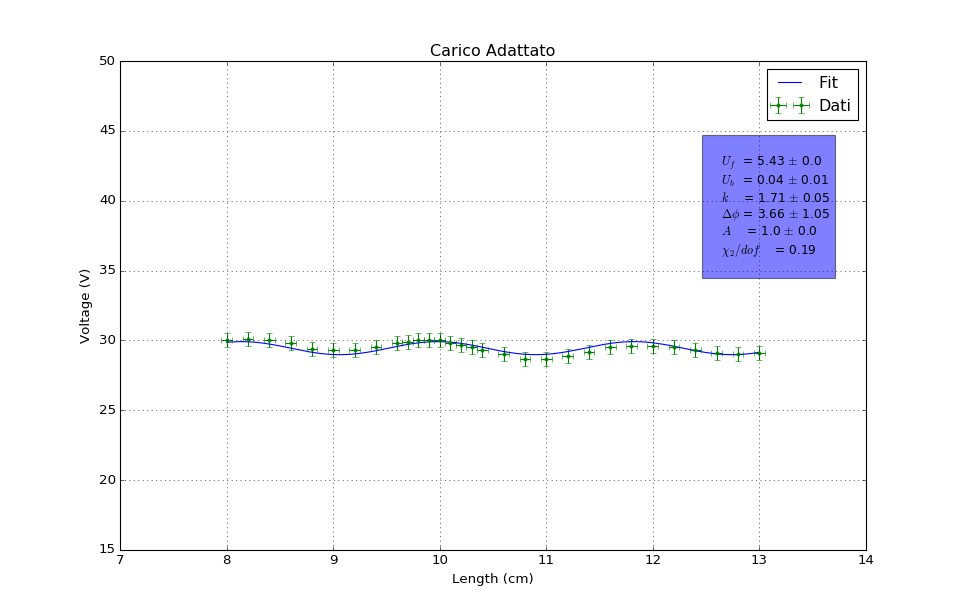

(15.0, 50)

In [12]:
%matplotlib notebook
x_adattato, y_adattato = np.genfromtxt('data_adattato.txt', skip_header=1, unpack=True)

model_adattato = Model(fit_function)
data_adattato = Data(x_adattato, y_adattato, wd=np.full( (1, np.size(x_adattato)), 1/sigma_x**2),\
            we=np.full((1, np.size(y_adattato)), 1/sigma_y**2))
myodr = ODR(data_adattato, model_adattato, beta0=[5.62, 1.35, 1.72, 2.8, 1], ifixb=[1, 1, 1, 1, 0])
myoutput = myodr.run()
myoutput.pprint()

chi_2            = myoutput.sum_square
dof              = np.size(x_adattato) - 1
chi_2_ridotto    = chi_2/dof
U_F              = myoutput.beta[0]
sigma_U_F        = myoutput.sd_beta[0]
U_B              = myoutput.beta[1]
sigma_U_B        = myoutput.sd_beta[1]
k                = myoutput.beta[2]
sigma_k          = myoutput.sd_beta[2]
delta_phi        = myoutput.beta[3]
sigma_delta_phi  = myoutput.sd_beta[3]
amplitude        = myoutput.beta[4]
sigma_amplitude  = myoutput.sd_beta[4]
parameters       = [U_F, U_B, k, delta_phi, amplitude]

parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(round(U_F,2), round(sigma_U_F,2), round(U_B,2), round(sigma_U_B,2), round(k,2), round(sigma_k,2),
          round(delta_phi,2), round(sigma_delta_phi,2), round(amplitude,2), round(sigma_amplitude,2),
          round(chi_2_ridotto, 2))

x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Fit')
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(12.5, 35, parameters_text, size=11,
        bbox={ 'alpha':0.5, 'pad':4})
ax.grid()
ax.legend()
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Length (cm)')
ax.set_title('Carico Adattato')
ax.set_ylim(15., 50)

## Fit del carico aperto

Utilizziamo il carico adattato `data_aperto.txt` e lo fittiamo.

Beta: [ 5.40720898  1.12619213  1.72653123  2.93245994  1.        ]
Beta Std Error: [ 0.00821592  0.00899134  0.00623121  0.13217439  0.        ]
Beta Covariance: [[  3.46615515e-04  -1.48991882e-04   5.18056222e-07  -1.93849053e-05
    0.00000000e+00]
 [ -1.48991882e-04   4.15130530e-04   3.88634179e-06  -4.19078543e-05
    0.00000000e+00]
 [  5.18056222e-07   3.88634179e-06   1.99379685e-04  -4.19692533e-03
    0.00000000e+00]
 [ -1.93849053e-05  -4.19078543e-05  -4.19692533e-03   8.97079065e-02
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
Residual Variance: 0.19474391478852332
Inverse Condition #: 0.006297059011571296
Reason(s) for Halting:
  Sum of squares convergence


<IPython.core.display.Javascript object>


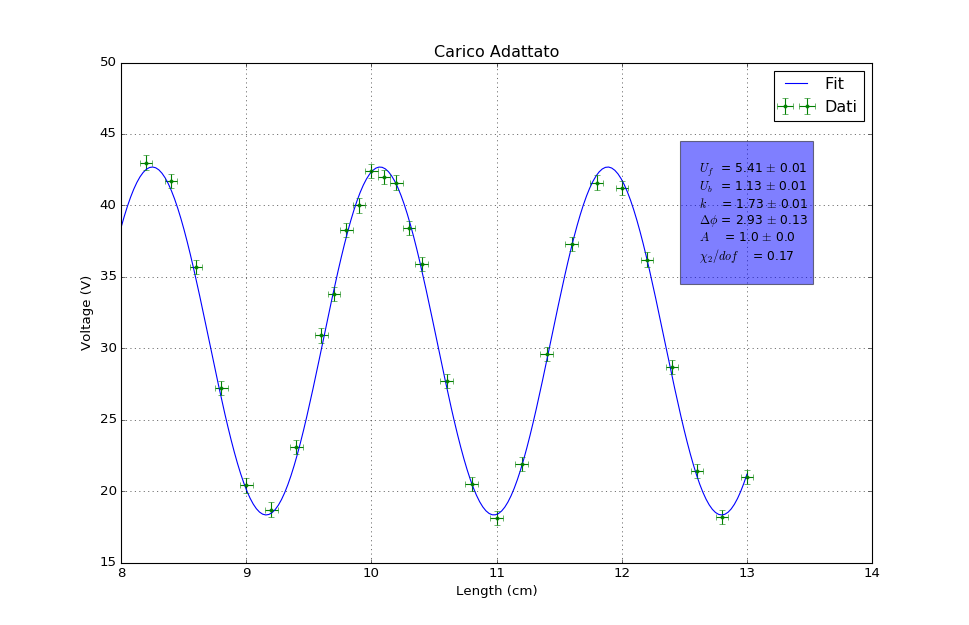

(15.0, 50)

In [13]:
%matplotlib notebook
x_adattato, y_adattato = np.genfromtxt('data_aperto.txt', skip_header=1, unpack=True)

model_adattato = Model(fit_function)
data_adattato = Data(x_adattato, y_adattato, wd=np.full( (1, np.size(x_adattato)), 1/sigma_x**2),\
            we=np.full((1, np.size(y_adattato)), 1/sigma_y**2))
myodr = ODR(data_adattato, model_adattato, beta0=[5.62, 1.35, 1.72, 2.8, 1], ifixb=[1, 1, 1, 1, 0])
myoutput = myodr.run()
myoutput.pprint()

chi_2            = myoutput.sum_square
dof              = np.size(x_adattato) - 1
chi_2_ridotto    = chi_2/dof
U_F              = myoutput.beta[0]
sigma_U_F        = myoutput.sd_beta[0]
U_B              = myoutput.beta[1]
sigma_U_B        = myoutput.sd_beta[1]
k                = myoutput.beta[2]
sigma_k          = myoutput.sd_beta[2]
delta_phi        = myoutput.beta[3]
sigma_delta_phi  = myoutput.sd_beta[3]
amplitude        = myoutput.beta[4]
sigma_amplitude  = myoutput.sd_beta[4]
parameters       = [U_F, U_B, k, delta_phi, amplitude]

parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(round(U_F,2), round(sigma_U_F,2), round(U_B,2), round(sigma_U_B,2), round(k,2), round(sigma_k,2),
          round(delta_phi,2), round(sigma_delta_phi,2), round(amplitude,2), round(sigma_amplitude,2),
          round(chi_2_ridotto, 2))

x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Fit')
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(12.5, 35, parameters_text, size=11,
        bbox={ 'alpha':0.5, 'pad':4})
ax.grid()
ax.legend()
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Length (cm)')
ax.set_title('Carico Adattato')
ax.set_ylim(15., 50)

## Analisi con horn

Utilizziamo il carico adattato `data_aperto.txt` e lo fittiamo.

Beta: [ 5.23556156  0.23511296  1.721663    1.74773298  1.        ]
Beta Std Error: [ 0.00741964  0.00982018  0.01665072  0.35308027  0.        ]
Beta Covariance: [[  1.13982998e-04  -3.13795838e-05   5.40656768e-05  -1.18430748e-03
    0.00000000e+00]
 [ -3.13795838e-05   1.99670612e-04  -1.53606307e-05   2.83867552e-04
    0.00000000e+00]
 [  5.40656768e-05  -1.53606307e-05   5.74038553e-04  -1.20743392e-02
    0.00000000e+00]
 [ -1.18430748e-03   2.83867552e-04  -1.20743392e-02   2.58120134e-01
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
Residual Variance: 0.4829754139265143
Inverse Condition #: 0.005989049838364067
Reason(s) for Halting:
  Sum of squares convergence


<IPython.core.display.Javascript object>


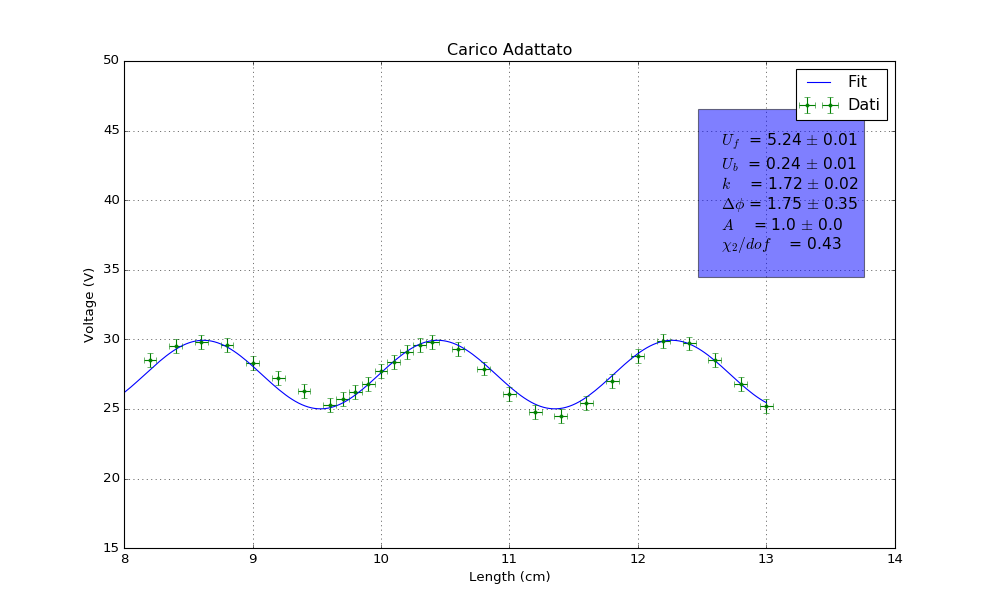

(15.0, 50)

In [9]:
%matplotlib notebook
x_adattato, y_adattato = np.genfromtxt('data_horn.txt', skip_header=1, unpack=True)

model_adattato = Model(fit_function)
data_adattato = Data(x_adattato, y_adattato, wd=np.full( (1, np.size(x_adattato)), 1/sigma_x**2),\
            we=np.full((1, np.size(y_adattato)), 1/sigma_y**2))
myodr = ODR(data_adattato, model_adattato, beta0=[5.62, 1.35, 1.72, 2.8, 1], ifixb=[1, 1, 1, 1, 0])
myoutput = myodr.run()
myoutput.pprint()

chi_2            = myoutput.sum_square
dof              = np.size(x_adattato) - 1
chi_2_ridotto    = chi_2/dof
U_F              = myoutput.beta[0]
sigma_U_F        = myoutput.sd_beta[0]
U_B              = myoutput.beta[1]
sigma_U_B        = myoutput.sd_beta[1]
k                = myoutput.beta[2]
sigma_k          = myoutput.sd_beta[2]
delta_phi        = myoutput.beta[3]
sigma_delta_phi  = myoutput.sd_beta[3]
amplitude        = myoutput.beta[4]
sigma_amplitude  = myoutput.sd_beta[4]
parameters       = [U_F, U_B, k, delta_phi, amplitude]

parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(round(U_F,2), round(sigma_U_F,2), round(U_B,2), round(sigma_U_B,2), round(k,2), round(sigma_k,2),
          round(delta_phi,2), round(sigma_delta_phi,2), round(amplitude,2), round(sigma_amplitude,2),
          round(chi_2_ridotto, 2))

x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Fit')
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(12.5, 35, parameters_text, size=14,
        bbox={ 'alpha':0.5, 'pad':4})
ax.grid()
ax.legend()
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Length (cm)')
ax.set_title('Carico Adattato')
ax.set_ylim(15., 50)

## Analisi con configurazione riflettente

Utilizziamo il file `data_riflettente.txt`

Beta: [ 5.12310771  4.3654063   1.7124199   0.65452659  1.        ]
Beta Std Error: [ 0.14136283  0.14284306  0.01042072  0.21997379  0.        ]
Beta Covariance: [[  2.38855974e-02  -2.32477956e-02  -9.83678316e-05   1.98013358e-03
    0.00000000e+00]
 [ -2.32477956e-02   2.43884355e-02   2.64683045e-05  -4.70619536e-04
    0.00000000e+00]
 [ -9.83678316e-05   2.64683045e-05   1.29795844e-04  -2.71531114e-03
    0.00000000e+00]
 [  1.98013358e-03  -4.70619536e-04  -2.71531114e-03   5.78372320e-02
    0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]]
Residual Variance: 0.8366317826099166
Inverse Condition #: 0.0001288708778025642
Reason(s) for Halting:
  Sum of squares convergence


<IPython.core.display.Javascript object>


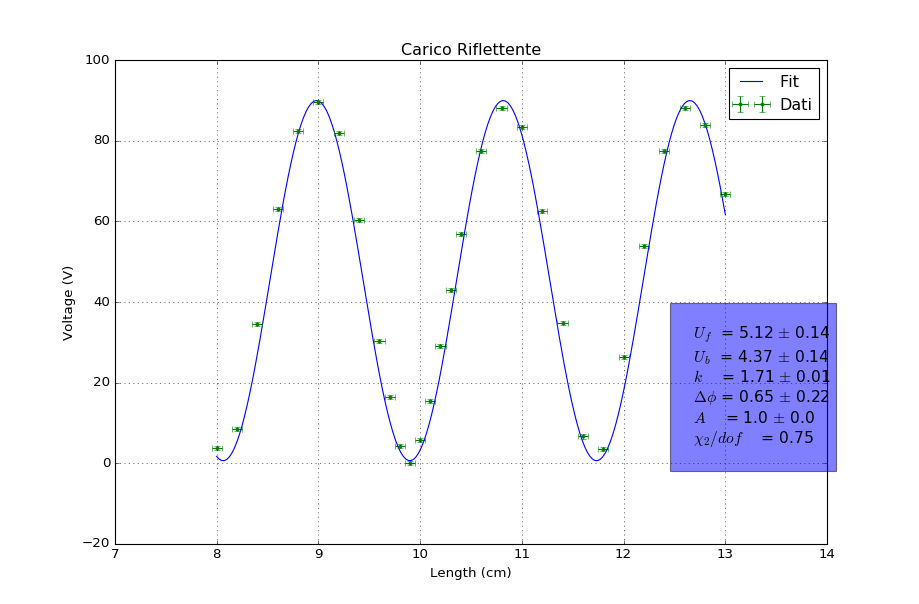

In [36]:
%matplotlib notebook
x_adattato, y_adattato = np.genfromtxt('data_riflettente.txt', skip_header=1, unpack=True)

model_adattato = Model(fit_function)
data_adattato = Data(x_adattato, y_adattato, wd=np.full( (1, np.size(x_adattato)), 1/sigma_x**2),\
            we=np.full((1, np.size(y_adattato)), 1/sigma_y**2))
myodr = ODR(data_adattato, model_adattato, beta0=[5.04, 4.46, 1.74, 0., 1], ifixb=[1, 1, 1, 1, 0], maxit=1000)
myoutput = myodr.run()
myoutput.pprint()

chi_2            = myoutput.sum_square
dof              = np.size(x_adattato) - 1
chi_2_ridotto    = chi_2/dof
U_F              = myoutput.beta[0]
sigma_U_F        = myoutput.sd_beta[0]
U_B              = myoutput.beta[1]
sigma_U_B        = myoutput.sd_beta[1]
k                = myoutput.beta[2]
sigma_k          = myoutput.sd_beta[2]
delta_phi        = myoutput.beta[3]
sigma_delta_phi  = myoutput.sd_beta[3]
amplitude        = myoutput.beta[4]
sigma_amplitude  = myoutput.sd_beta[4]
parameters       = [U_F, U_B, k, delta_phi, amplitude]

parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(round(U_F,2), round(sigma_U_F,2), round(U_B,2), round(sigma_U_B,2), round(k,2), round(sigma_k,2),
          round(delta_phi,2), round(sigma_delta_phi,2), round(amplitude,2), round(sigma_amplitude,2),
          round(chi_2_ridotto, 2))

x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
ax.plot(x, y, label='Fit')
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
ax.text(12.5, 0, parameters_text, size=14,
        bbox={ 'alpha':0.5, 'pad':4})
ax.grid()
ax.legend()
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Length (cm)')
ax.set_title('Carico Riflettente')
#ax.set_ylim(15., 50)

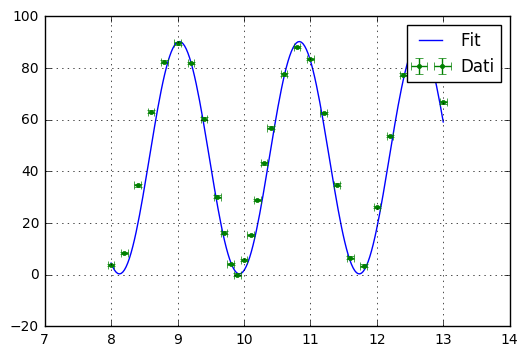

In [34]:
# importo le librerire per visualizzare i widgets
from ipywidgets import *
from IPython.display import display
%matplotlib inline

# leggo i dati
x_adattato, y_adattato = np.genfromtxt('data_riflettente.txt', skip_header=1, unpack=True)

def execute_fit(x, y, sigma_x, sigma_y, fit_function, beta0, ifixb=[1,1,1,1,1]):
    # eseguo il fit dei dati usando come pesi le deviazioni standard e come parametri
    # iniziali quelli definiti nel parametro 'beta0'
    model_adattato = Model(fit_function)
    data_adattato = Data(x, y, wd=np.full( (1, np.size(x)), 1/sigma_x**2),\
            we=np.full((1, np.size(y)), 1/sigma_y**2))
    myodr = ODR(data_adattato, model_adattato, beta0=beta0, ifixb=ifixb)
    myoutput = myodr.run()

    # salvo i parametri ottenuti
    chi_2            = myoutput.sum_square
    dof              = np.size(x_adattato) - 1
    chi_2_ridotto    = round(chi_2/dof, 2)
    U_F              = round(myoutput.beta[0], 5)
    sigma_U_F        = round(myoutput.sd_beta[0], 5)
    U_B              = round(myoutput.beta[1], 5)
    sigma_U_B        = round(myoutput.sd_beta[1], 5)
    k                = round(myoutput.beta[2], 2)
    sigma_k          = round(myoutput.sd_beta[2], 2)
    delta_phi        = round(myoutput.beta[3], 2)
    sigma_delta_phi  = round(myoutput.sd_beta[3], 2)
    amplitude        = round(myoutput.beta[4], 2)
    sigma_amplitude  = round(myoutput.sd_beta[4], 2)
    parameters       = [chi_2, dof, chi_2_ridotto, U_F, sigma_U_F, U_B, 
        sigma_U_B, k, sigma_k, delta_phi, sigma_delta_phi, amplitude, 
        sigma_amplitude]

# preparo la stringa di testo da visualizzare nel grafico
parameters_text = """
    $U_f$  = {} $\pm$ {} 
    $U_b$  = {} $\pm$ {}
    $k$    = {} $\pm$ {}
    $\Delta \phi$ = {} $\pm$ {}
    $A$    = {} $\pm$ {}
    $\chi_2/dof$    = {} 
""".format(U_F, sigma_U_F, U_B, sigma_U_B, k, sigma_k,
          delta_phi, sigma_delta_phi, amplitude, sigma_amplitude,
          chi_2_ridotto)

# plotto i dati da manipolare e i dati reali
x = np.linspace(8, 13, 200)
y = fit_function(parameters, x)
fig, ax = plt.subplots()
plot_data, = ax.plot(x, y, label='Fit')

# definisco la funzione che viene chiamata quando un widget cambia valore
def manipulate(U_F, U_B, k, delta_phi, amplitude):
    x = np.linspace(8, 13, 200)
    params = [U_F, U_B, k, delta_phi, amplitude]
    plot_data.set_ydata(fit_function(params, x))
    display(fig)

# definisco i ranges, gli step e i valori iniziali dei vari parametri che voglio modificare
options = interactive(manipulate, U_F=widgets.FloatSlider(min=0,max=6,step=0.05,value=parameters[0]), 
         U_B=widgets.FloatSlider(min=0,max=6,step=0.05,value=parameters[1]), 
         k=widgets.FloatSlider(min=-10,max=180,step=5,value=parameters[2]),
         delta_phi=widgets.FloatSlider(min=-3,max=10,step=0.05,value=parameters[3]), 
         amplitude=widgets.FloatSlider(min=0,max=2,step=0.02,value=parameters[4]))
display(options)


# definisco la funzione che viene chiamata quando il bottone viene cliccato
def handle_fit(obj):
    params = [obj.data['params']]
    execute_fit(obj.data['x'], 
                obj.data['y'], 
                obj.data['sigma_x'], 
                obj.data['sigma_y'], 
                obj.data['fit_function'], 
                params)
    print(obj.data)
    
# impacchettizzo tutti i dati per poter eseguire un fit completo 
data = {
    'x': x_adattato,
    'y': y_adattato,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'fit_function': fit_function,
    'params': options.kwargs
    #'ifixb': [0, 0, 0, 1, 1]
}

# giusto perchè siamo belli aggiungiamo un bottone che quando viene schiacciato
# riesegue il fit utilizzando i parametri impostati
'''
fit_button = widgets.Button(description="Fit this function", data=data)
display(fit_button)
fit_button.on_click(handle_fit)
'''

# plotto i dati reali con le loro incertezze
ax.errorbar(x_adattato, y_adattato, xerr=sigma_x, yerr=sigma_y, fmt='.', label='Dati')
#ax.text(8, 5, parameters_text, size=14,
#        bbox={ 'alpha':0.5, 'pad':10})
ax.grid()
ax.legend()
#ax.set_ylim(0., 40)

# Lobi di radiazione

Si misura la potenza nello spazio e la si visualizza con un grafico in coordinate polari

<IPython.core.display.Javascript object>


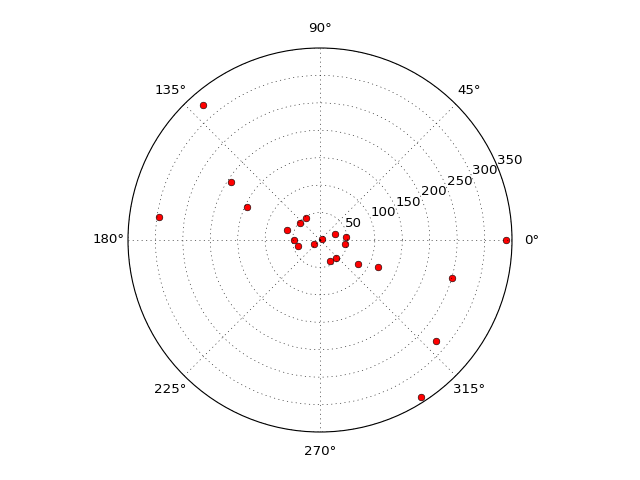

<IPython.core.display.Javascript object>


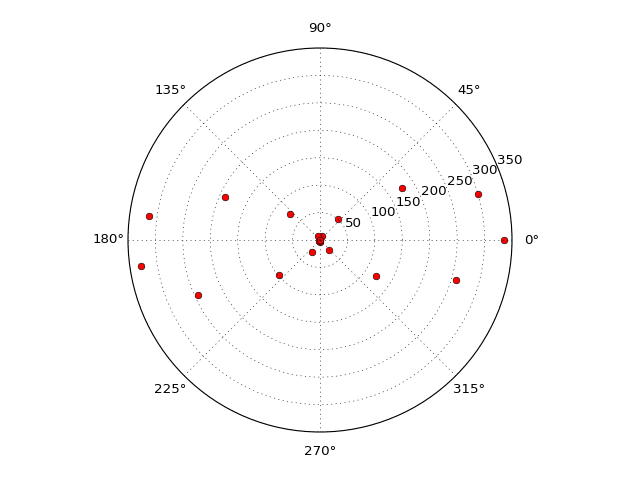

In [53]:
x_lobo_verticale, y_lobo_verticale = np.genfromtxt('data_lobo_verticale.txt', skip_header=1, unpack=True, usecols=(0,1))
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8], polar=True)
ax.plot(x_lobo_verticale, y_lobo_verticale, 'ro')

x_lobo_orizzonale, y_lobo_orizzontale = np.genfromtxt('data_lobo_orizzontale.txt', skip_header=1, unpack=True, usecols=(0,1))
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8], polar=True)
ax.plot(x_lobo_orizzonale, y_lobo_orizzontale, 'ro')